# Mode prediction -- multiple steps -- different features

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [101]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

## Processing functions

In [102]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [103]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))

    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    f = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(np.array(pred), color=colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.show()

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))
    
    print(acc)
    print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    _, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()


'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    _, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.show()

In [104]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [105]:
op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

test = read_dataset(dataset, campaigns=[op2_overlap[0]])
train = read_dataset(dataset, campaigns=op2_overlap[1:3])
test_campaigns = test['campaign'].unique().tolist()

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[op2_overlap[3]])
test = pd.concat([route_to_add[5350::], test])
test.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [106]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

## 1 step ahead

In [107]:
# parameters
n_steps_in = 2
n_steps_out = 1
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.442,0.990,0.072,0.526,0.845,0.044,[0.4424255229241496],[0.5257510729613734]
1,SINR,0.488,0.631,0.354,0.645,0.640,0.635,[0.4876399746461018],[0.6446709585121603]
2,RSRQ,0.560,0.595,0.839,0.515,0.504,0.937,[0.5596873019226706],[0.5146638054363376]
3,"RSRP, SINR",0.526,0.604,0.613,0.614,0.573,0.845,[0.5256708218888654],[0.6142703862660944]
4,"RSRP, RSRQ",0.503,0.973,0.177,0.544,0.778,0.102,[0.5026410310585252],[0.544170243204578]
5,"SINR, RSRQ",0.533,0.601,0.663,0.623,0.576,0.886,[0.5326431438833721],[0.6233905579399142]
6,"RSRP, SINR, RSRQ",0.601,0.601,1.000,0.492,0.492,1.000,[0.6006761039509825],[0.4917739628040057]
7,SSS_RSRP,0.516,0.982,0.197,0.625,0.987,0.241,[0.5155292626241285],[0.6253576537911302]
8,SSS_SINR,0.659,0.819,0.555,0.784,0.810,0.734,[0.6589900697232199],[0.7843347639484979]
9,SSS_RSRQ,0.577,0.770,0.422,0.740,0.796,0.634,[0.5770124656665963],[0.7401645207439199]


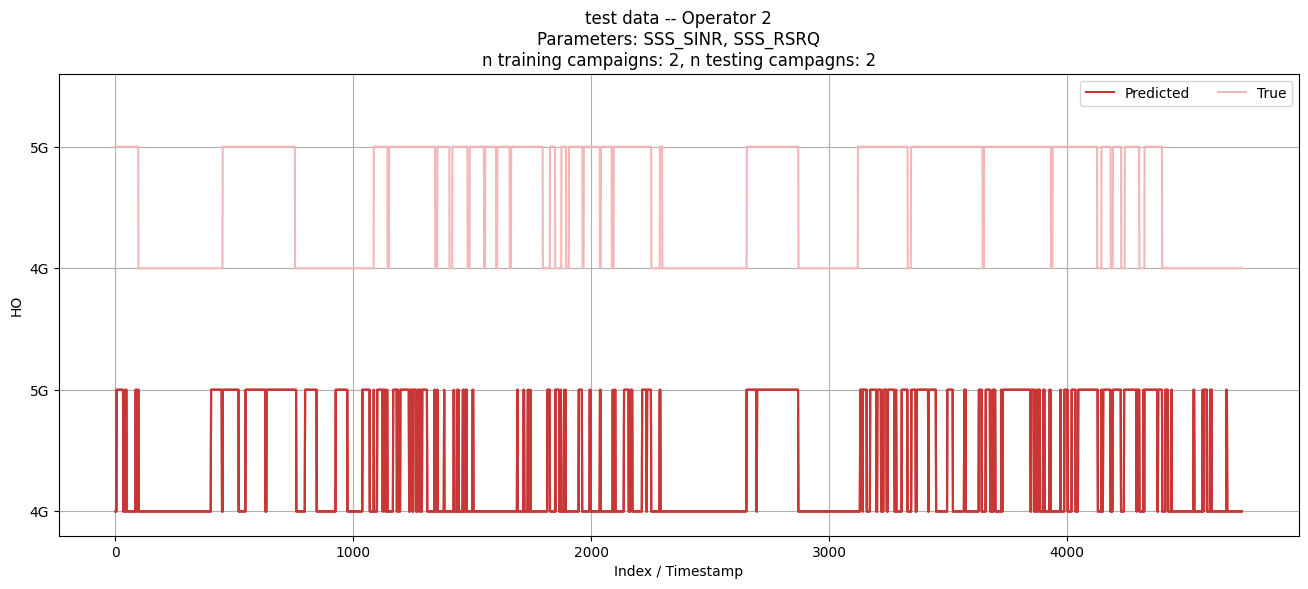

In [108]:

combination = 'SSS_SINR, SSS_RSRQ'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

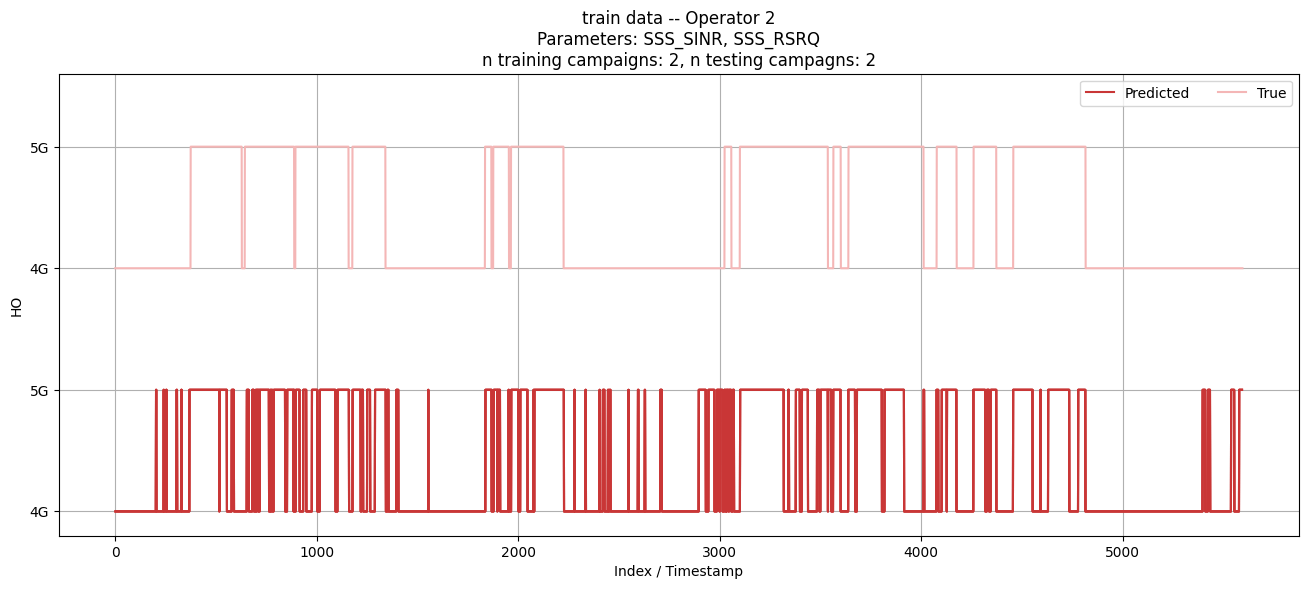

In [109]:
plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

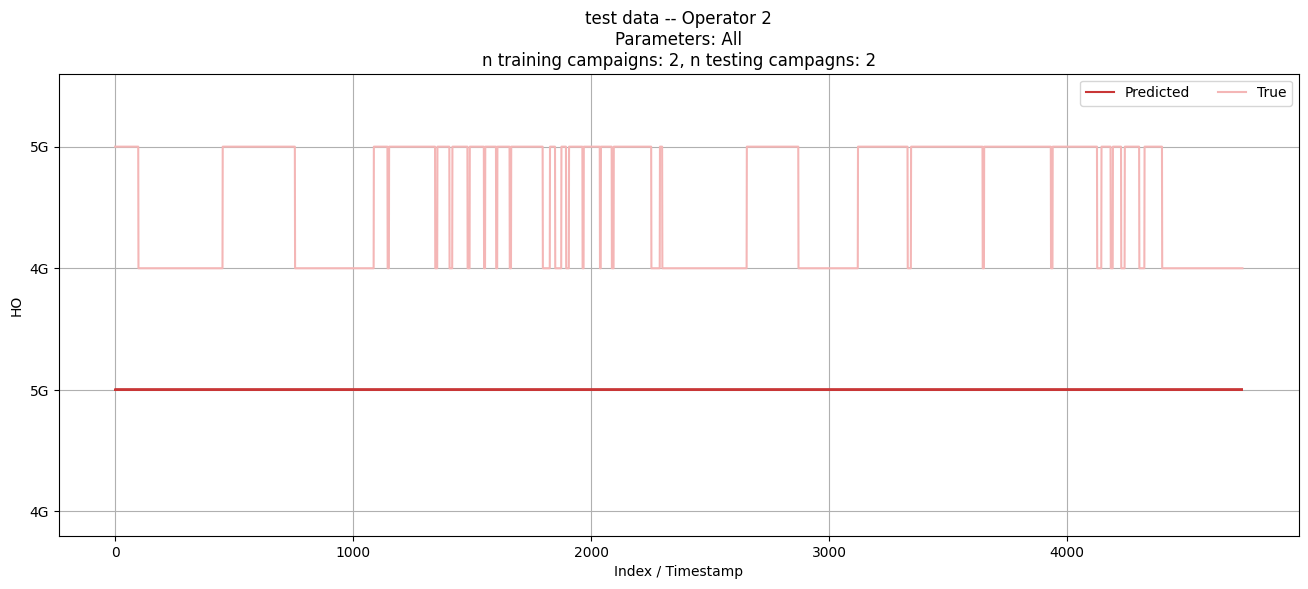

In [110]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)


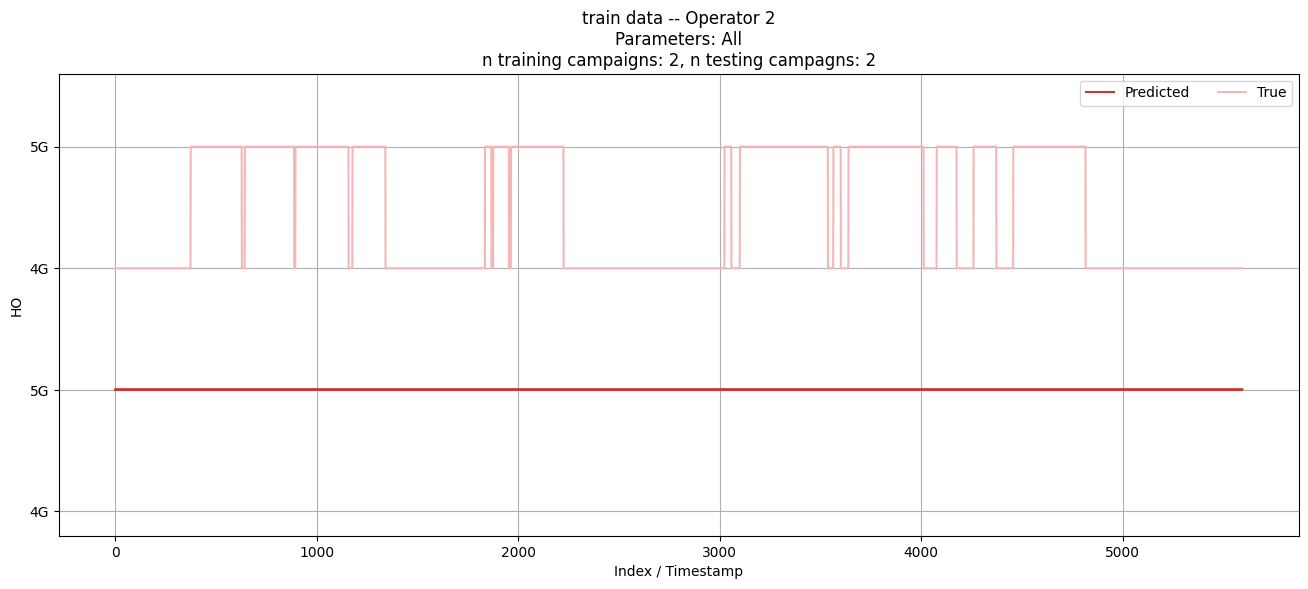

In [111]:
plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

## 2 steps ahead

In [112]:
# parameters
n_steps_in = 2
n_steps_out = 2
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.417,0.983,0.030,0.519,0.864,0.028,"[0.41703656732191924, 0.41703656732191924]","[0.5194991055456172, 0.5194991055456172]"
1,SINR,0.447,0.581,0.286,0.641,0.647,0.596,"[0.4478968505601353, 0.44620587613612345]","[0.6404293381037567, 0.6420393559928443]"
2,RSRQ,0.541,0.587,0.797,0.504,0.498,0.888,"[0.5400549566687803, 0.5411118156837877]","[0.5041144901610017, 0.5033989266547406]"
3,"RSRP, SINR",0.473,0.578,0.457,0.631,0.597,0.767,"[0.4738955823293173, 0.4726273515113084]","[0.6241502683363148, 0.6381037567084079]"
4,"RSRP, RSRQ",0.525,0.602,0.618,0.600,0.595,0.581,"[0.5290636229127035, 0.5214542380046502]","[0.598211091234347, 0.6008944543828265]"
5,"SINR, RSRQ",0.484,0.580,0.509,0.649,0.602,0.842,"[0.48425280067638976, 0.4829845698583809]","[0.648479427549195, 0.6488372093023256]"
6,"RSRP, SINR, RSRQ",0.601,0.601,1.000,0.493,0.493,1.000,"[0.6009300359332065, 0.6005072923272036]","[0.49338103756708407, 0.49338103756708407]"
7,SSS_RSRP,0.601,0.601,1.000,0.492,0.492,1.000,"[0.6009300359332065, 0.6005072923272036]","[0.4919499105545617, 0.4919499105545617]"
8,SSS_SINR,0.644,0.813,0.528,0.795,0.835,0.727,"[0.6457408581695202, 0.641724793912492]","[0.7967799642218247, 0.7930232558139535]"
9,SSS_RSRQ,0.597,0.765,0.474,0.727,0.749,0.669,"[0.5988163179031917, 0.5943775100401606]","[0.7282647584973166, 0.7250447227191413]"


Number of predicted 5G point: 2928
Number of true 5G points: 5684

[0.6696258719086874, 0.6662439230606637]
[0.8153846153846154, 0.8112701252236136]


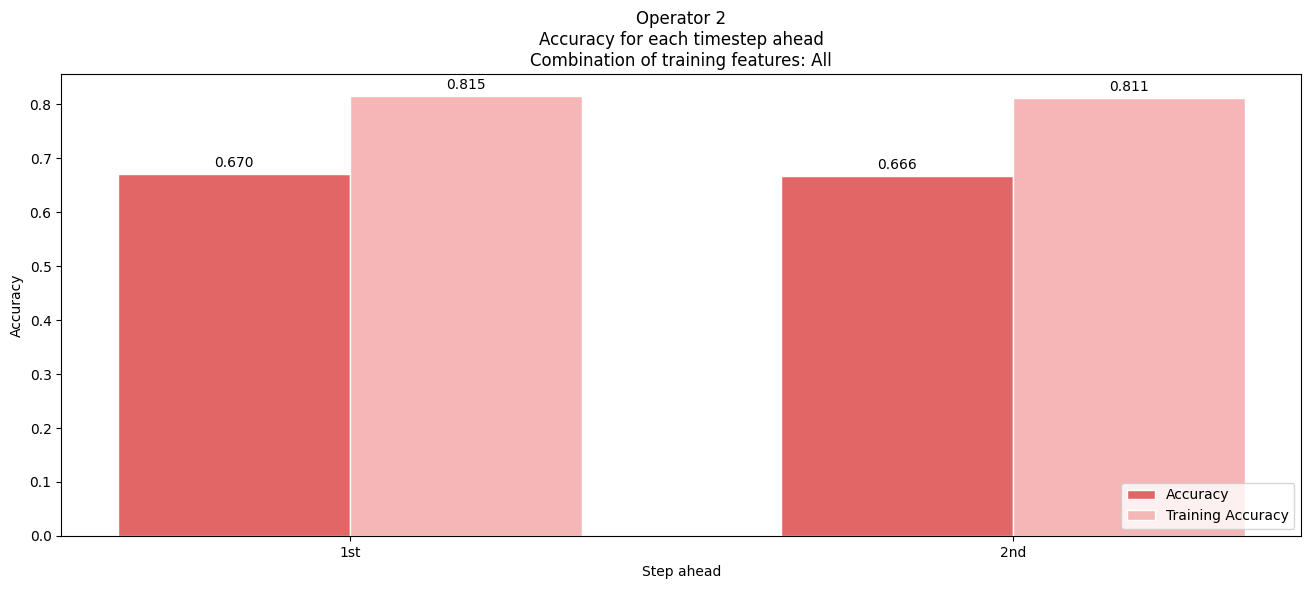

In [113]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

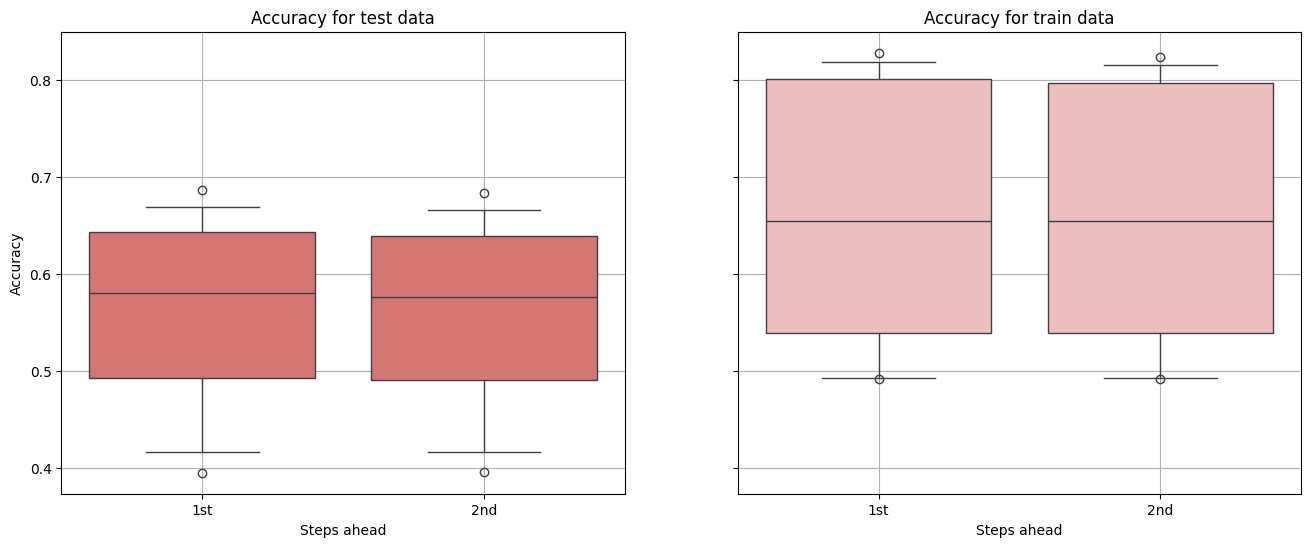

In [114]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)

## 3 steps ahead

In [115]:
# parameters
n_steps_in = 3
n_steps_out = 3
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.601,0.601,1.000,0.492,0.492,1.000,"[0.6010154431986461, 0.6005923418658768, 0.600...","[0.49230218403150733, 0.49230218403150733, 0.4..."
1,SINR,0.469,0.594,0.362,0.641,0.623,0.684,"[0.47027713137296384, 0.46858472604188706, 0.4...","[0.6408879341210169, 0.6412459720730398, 0.641..."
2,RSRQ,0.566,0.596,0.860,0.517,0.505,0.949,"[0.566744235244341, 0.5661095832451872, 0.5656...","[0.5193340494092373, 0.5155746509129968, 0.515..."
3,"RSRP, SINR",0.517,0.609,0.546,0.611,0.580,0.755,"[0.5172413793103449, 0.5170298286439602, 0.517...","[0.611170784103115, 0.6092015753669889, 0.6120..."
4,"RSRP, RSRQ",0.503,0.577,0.645,0.570,0.551,0.687,"[0.5032790353289612, 0.5032790353289612, 0.503...","[0.5685642678123881, 0.568922305764411, 0.5728..."
5,"SINR, RSRQ",0.539,0.596,0.724,0.657,0.592,0.974,"[0.5392426486143431, 0.5381848952824202, 0.540...","[0.6587898317221625, 0.6595059076262084, 0.653..."
6,"RSRP, SINR, RSRQ",0.471,0.574,0.460,0.645,0.624,0.705,"[0.47323884070234823, 0.4723926380368098, 0.46...","[0.6459004654493377, 0.6466165413533834, 0.643..."
7,SSS_RSRP,0.658,0.726,0.691,0.658,0.611,0.840,"[0.6623651364501798, 0.6579225724561032, 0.654...","[0.659326888650197, 0.6571786609380594, 0.6589..."
8,SSS_SINR,0.659,0.813,0.562,0.783,0.800,0.744,"[0.6619420351174106, 0.6600380791199493, 0.654...","[0.7875044754744003, 0.7819548872180451, 0.778..."
9,SSS_RSRQ,0.574,0.789,0.396,0.732,0.819,0.585,"[0.5771102178971864, 0.5739369579014174, 0.570...","[0.7350519155030433, 0.73218761188686, 0.72950..."


Number of predicted 5G point: 4039
Number of true 5G points: 8517

[0.6175163951766448, 0.6139200338481067, 0.6101121218531839]
[0.7599355531686359, 0.7568922305764411, 0.7540279269602578]


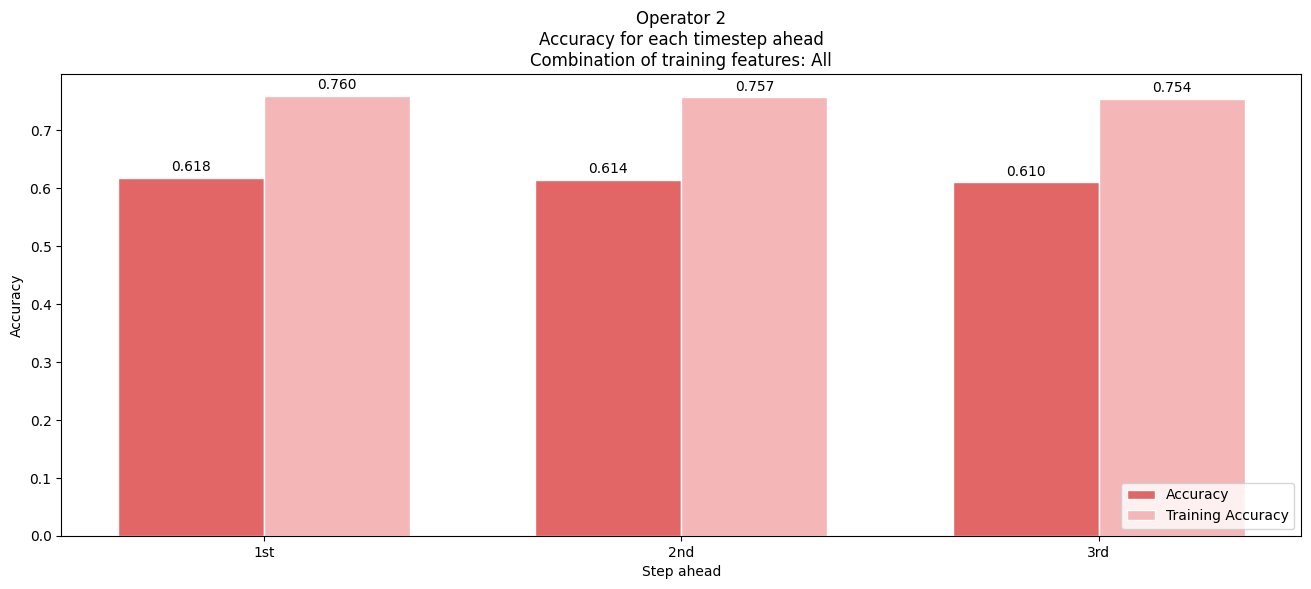

In [116]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

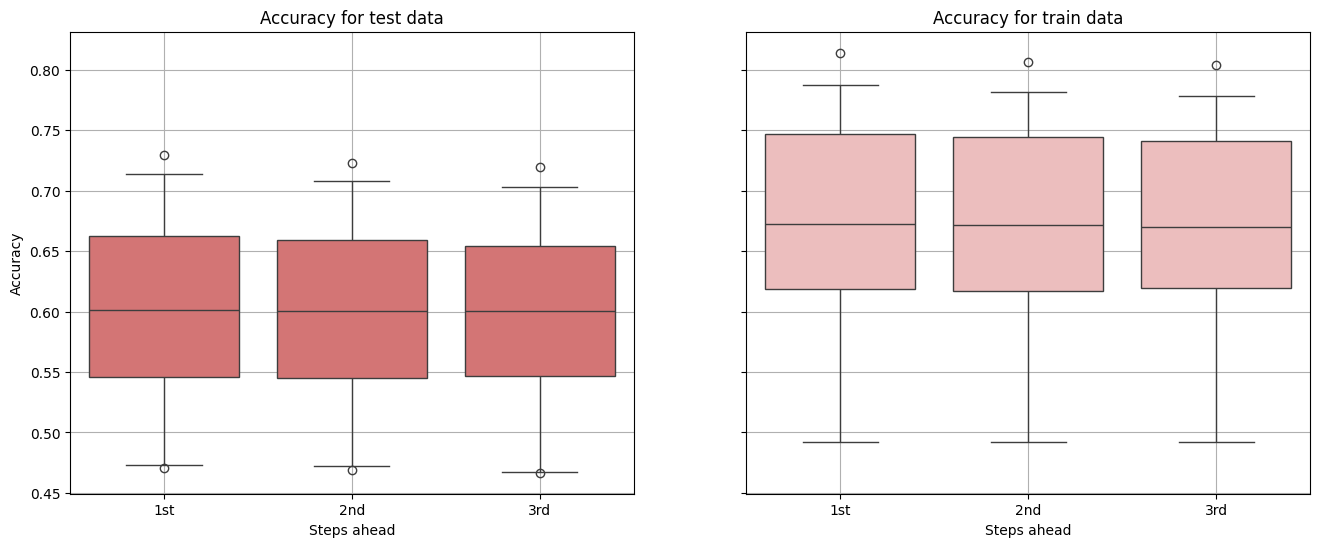

In [117]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)

## 5 steps ahead

In [118]:
# parameters
n_steps_in = 5
n_steps_out = 5
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.511,0.712,0.311,0.602,0.759,0.282,"[0.5115490570036024, 0.5079465988556897, 0.508...","[0.6011115095016135, 0.6011115095016135, 0.601..."
1,SINR,0.460,0.574,0.389,0.671,0.641,0.757,"[0.46492901038355583, 0.4611146429328247, 0.46...","[0.6712083183936894, 0.6713875941197562, 0.671..."
2,RSRQ,0.578,0.593,0.948,0.514,0.504,0.983,"[0.5776647594829413, 0.5763933036660309, 0.564...","[0.5177482968806024, 0.5179275726066691, 0.512..."
3,"RSRP, SINR",0.540,0.610,0.651,0.625,0.582,0.844,"[0.5418520873066328, 0.5414282687009959, 0.540...","[0.6242380781642166, 0.62459662961635, 0.62459..."
4,"RSRP, RSRQ",0.419,0.952,0.035,0.526,0.877,0.044,"[0.4193685102776012, 0.4195804195804196, 0.419...","[0.52491932592327, 0.5252778773754033, 0.52563..."
5,"SINR, RSRQ",0.475,0.592,0.401,0.667,0.643,0.732,"[0.4740411104047468, 0.4738292011019284, 0.473...","[0.6681606310505558, 0.6704912154894227, 0.667..."
6,"RSRP, SINR, RSRQ",0.518,0.617,0.521,0.657,0.618,0.798,"[0.5185420639966094, 0.5185420639966094, 0.518...","[0.6566869845822876, 0.6572248117604876, 0.656..."
7,SSS_RSRP,0.665,0.777,0.619,0.705,0.689,0.733,"[0.6749311294765841, 0.6696333969061242, 0.663...","[0.7086769451416278, 0.707422015059161, 0.7052..."
8,SSS_SINR,0.658,0.801,0.573,0.786,0.795,0.763,"[0.6668785759694851, 0.6624284806102988, 0.657...","[0.7929365363929723, 0.7898888490498387, 0.786..."
9,SSS_RSRQ,0.575,0.785,0.402,0.734,0.817,0.593,"[0.5810553083280356, 0.5772409408773045, 0.574...","[0.739870921477232, 0.7370025098601649, 0.7337..."


Number of predicted 5G point: 8191
Number of true 5G points: 14165

[0.6772621318075863, 0.6730239457512185, 0.6685738503920322, 0.6643356643356644, 0.6605212968849332]
[0.8192900681247759, 0.8158838293295088, 0.8126568662603083, 0.8097884546432413, 0.8063822158479742]


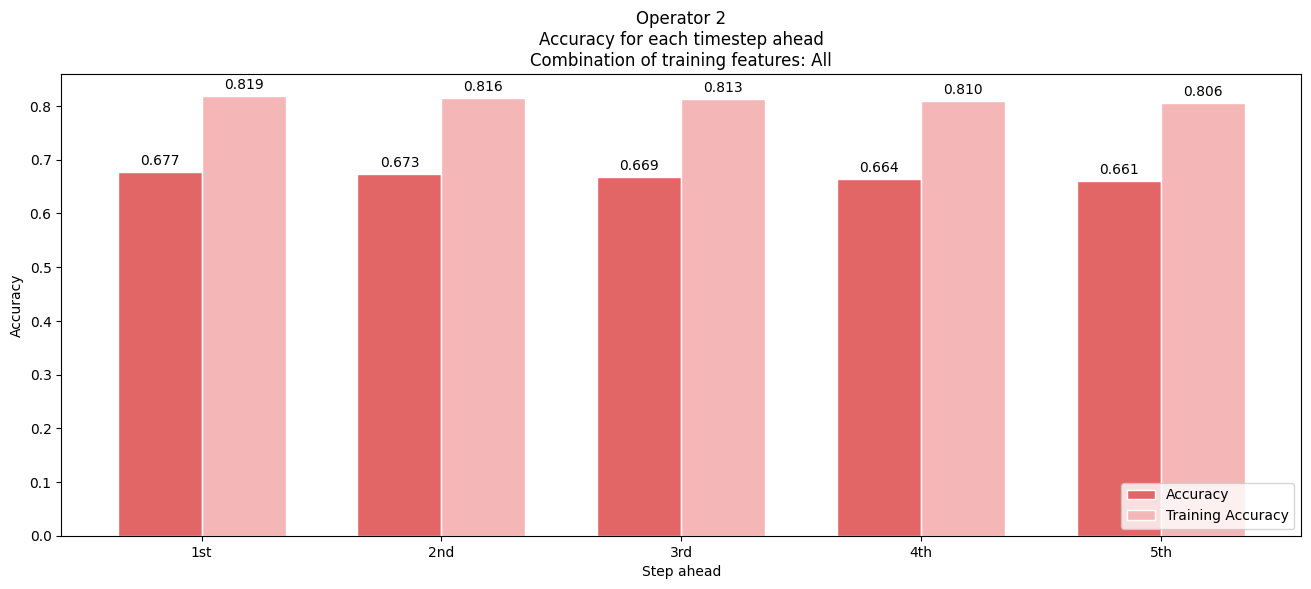

In [119]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

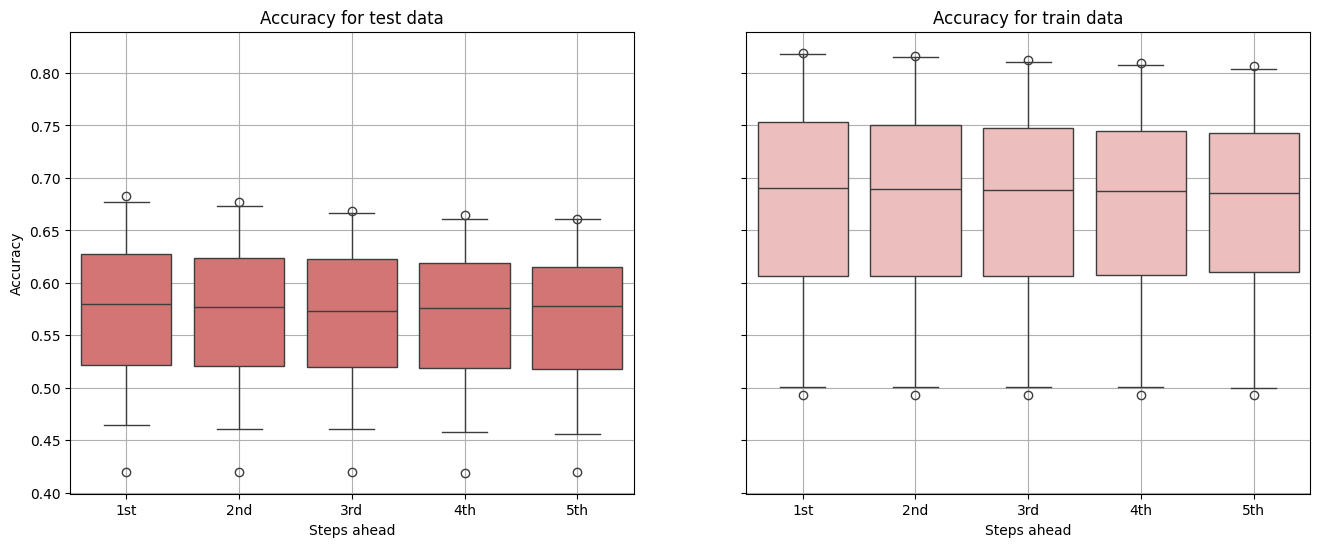

In [120]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)

## 10 steps ahead

In [121]:
# parameters
n_steps_in = 8
n_steps_out = 10
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_list,Accuracy_train_list
0,RSRP,0.487,0.571,0.588,0.585,0.573,0.632,"[0.49351477780140335, 0.49287688709334465, 0.4...","[0.5888169723121179, 0.5884573894282632, 0.587..."
1,SINR,0.510,0.597,0.565,0.633,0.592,0.829,"[0.5211567084839465, 0.5196682968318095, 0.517...","[0.6346637900035959, 0.6350233728874506, 0.635..."
2,RSRQ,0.587,0.598,0.952,0.524,0.510,0.969,"[0.588347863066128, 0.5874973421220497, 0.5864...","[0.5255303847536857, 0.5264293419633226, 0.526..."
3,"RSRP, SINR",0.525,0.605,0.603,0.635,0.592,0.842,"[0.5302998086327876, 0.5285987667446311, 0.526...","[0.6368212873067242, 0.6370010787486515, 0.637..."
4,"RSRP, RSRQ",0.547,0.615,0.654,0.598,0.599,0.566,"[0.5456091856261961, 0.5458218158622156, 0.545...","[0.6039194534340165, 0.6048184106436534, 0.599..."
5,"SINR, RSRQ",0.522,0.586,0.693,0.589,0.552,0.892,"[0.5290240272166702, 0.5283861365086115, 0.527...","[0.581984897518878, 0.5915138439410285, 0.5918..."
6,"RSRP, SINR, RSRQ",0.505,0.587,0.592,0.630,0.594,0.795,"[0.5035083988943228, 0.5026578779502445, 0.501...","[0.635203164329378, 0.6357425386551601, 0.6350..."
7,SSS_RSRP,0.400,0.000,0.000,0.506,1.000,0.000,"[0.39804380182862004, 0.39846906230065915, 0.3...","[0.5055735346997483, 0.5055735346997483, 0.505..."
8,SSS_SINR,0.647,0.790,0.562,0.785,0.794,0.763,"[0.664044227089092, 0.66021688284074, 0.655751...","[0.7984537935994247, 0.7953973390866594, 0.792..."
9,SSS_RSRQ,0.618,0.754,0.540,0.716,0.708,0.725,"[0.6276844567297469, 0.6244950031894535, 0.620...","[0.72851492268968, 0.7254584681769147, 0.72258..."


Number of predicted 5G point: 22747
Number of true 5G points: 28220

[0.6991282160323198, 0.6948756113119285, 0.6916861577716351, 0.6872209228152243, 0.6827556878588136, 0.6774399319583245, 0.6736125877099723, 0.6697852434616203, 0.6665957899213268, 0.6629810759089942]
[0.8351312477526069, 0.8313556274721323, 0.8277597986335851, 0.8252427184466019, 0.8227256382596189, 0.8202085580726357, 0.8171521035598706, 0.8128371089536138, 0.8101402373247033, 0.8052858683926645]


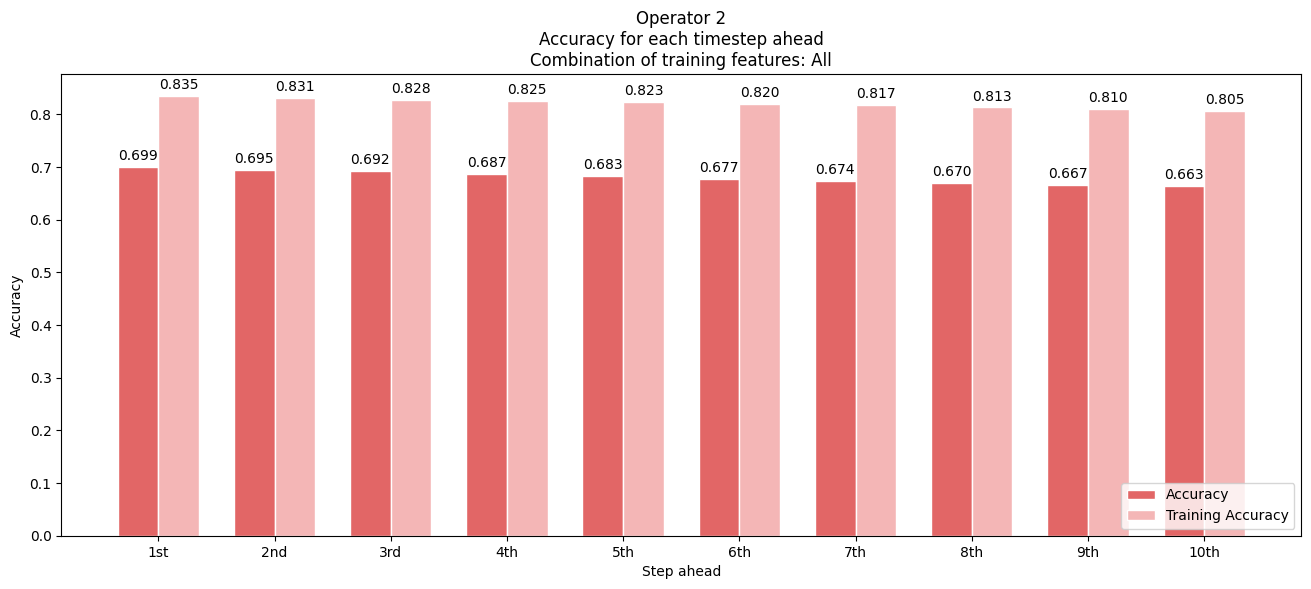

In [122]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

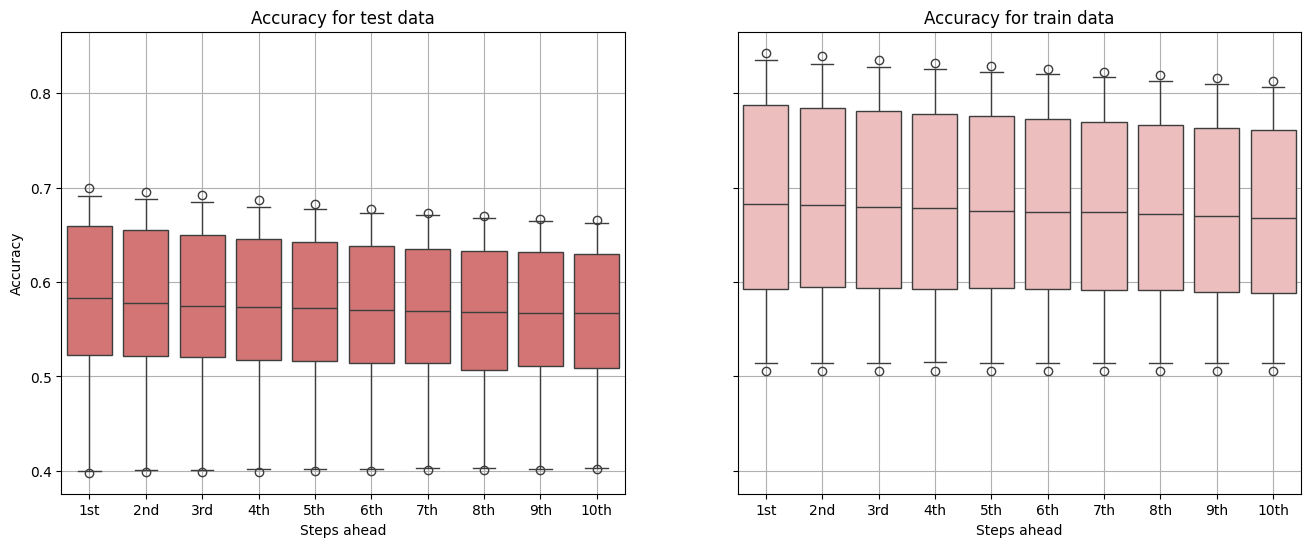

In [123]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)